In [531]:
import cv2
#from cv2 import imshow as imshow
import numpy as np
from google.colab.patches import cv2_imshow as imshow

In [532]:
img1 = cv2.imread('img.png')
img2 = cv2.imread('img1.png')
img3 = cv2.imread('health-benefits-apples-hero.webp')
img4 = cv2.imread("health-benefits-of-apples.png")
img5 = cv2.imread("red-apple-gala.webp")
img6 = cv2.imread("red-apple-gala-1.png")

In [533]:
def apply_log_kernel(image):
    # Convert the image to grayscale (LoG works on single channel images)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply a Laplacian of Gaussian filter
    # You can adjust the kernel size and sigma for better results
    sigma = 0.75  # Standard deviation for Gaussian kernel
    kernel_size = 5  # Size of the kernel

    # Use cv2 to apply the LoG filter
    log_image = cv2.GaussianBlur(gray_image, (kernel_size, kernel_size), sigma)
    log_image = cv2.Laplacian(log_image, cv2.CV_64F)

    # Convert to absolute value (to visualize edges better)
    log_image = cv2.convertScaleAbs(log_image)

    return log_image

Displaying result for img1.png:


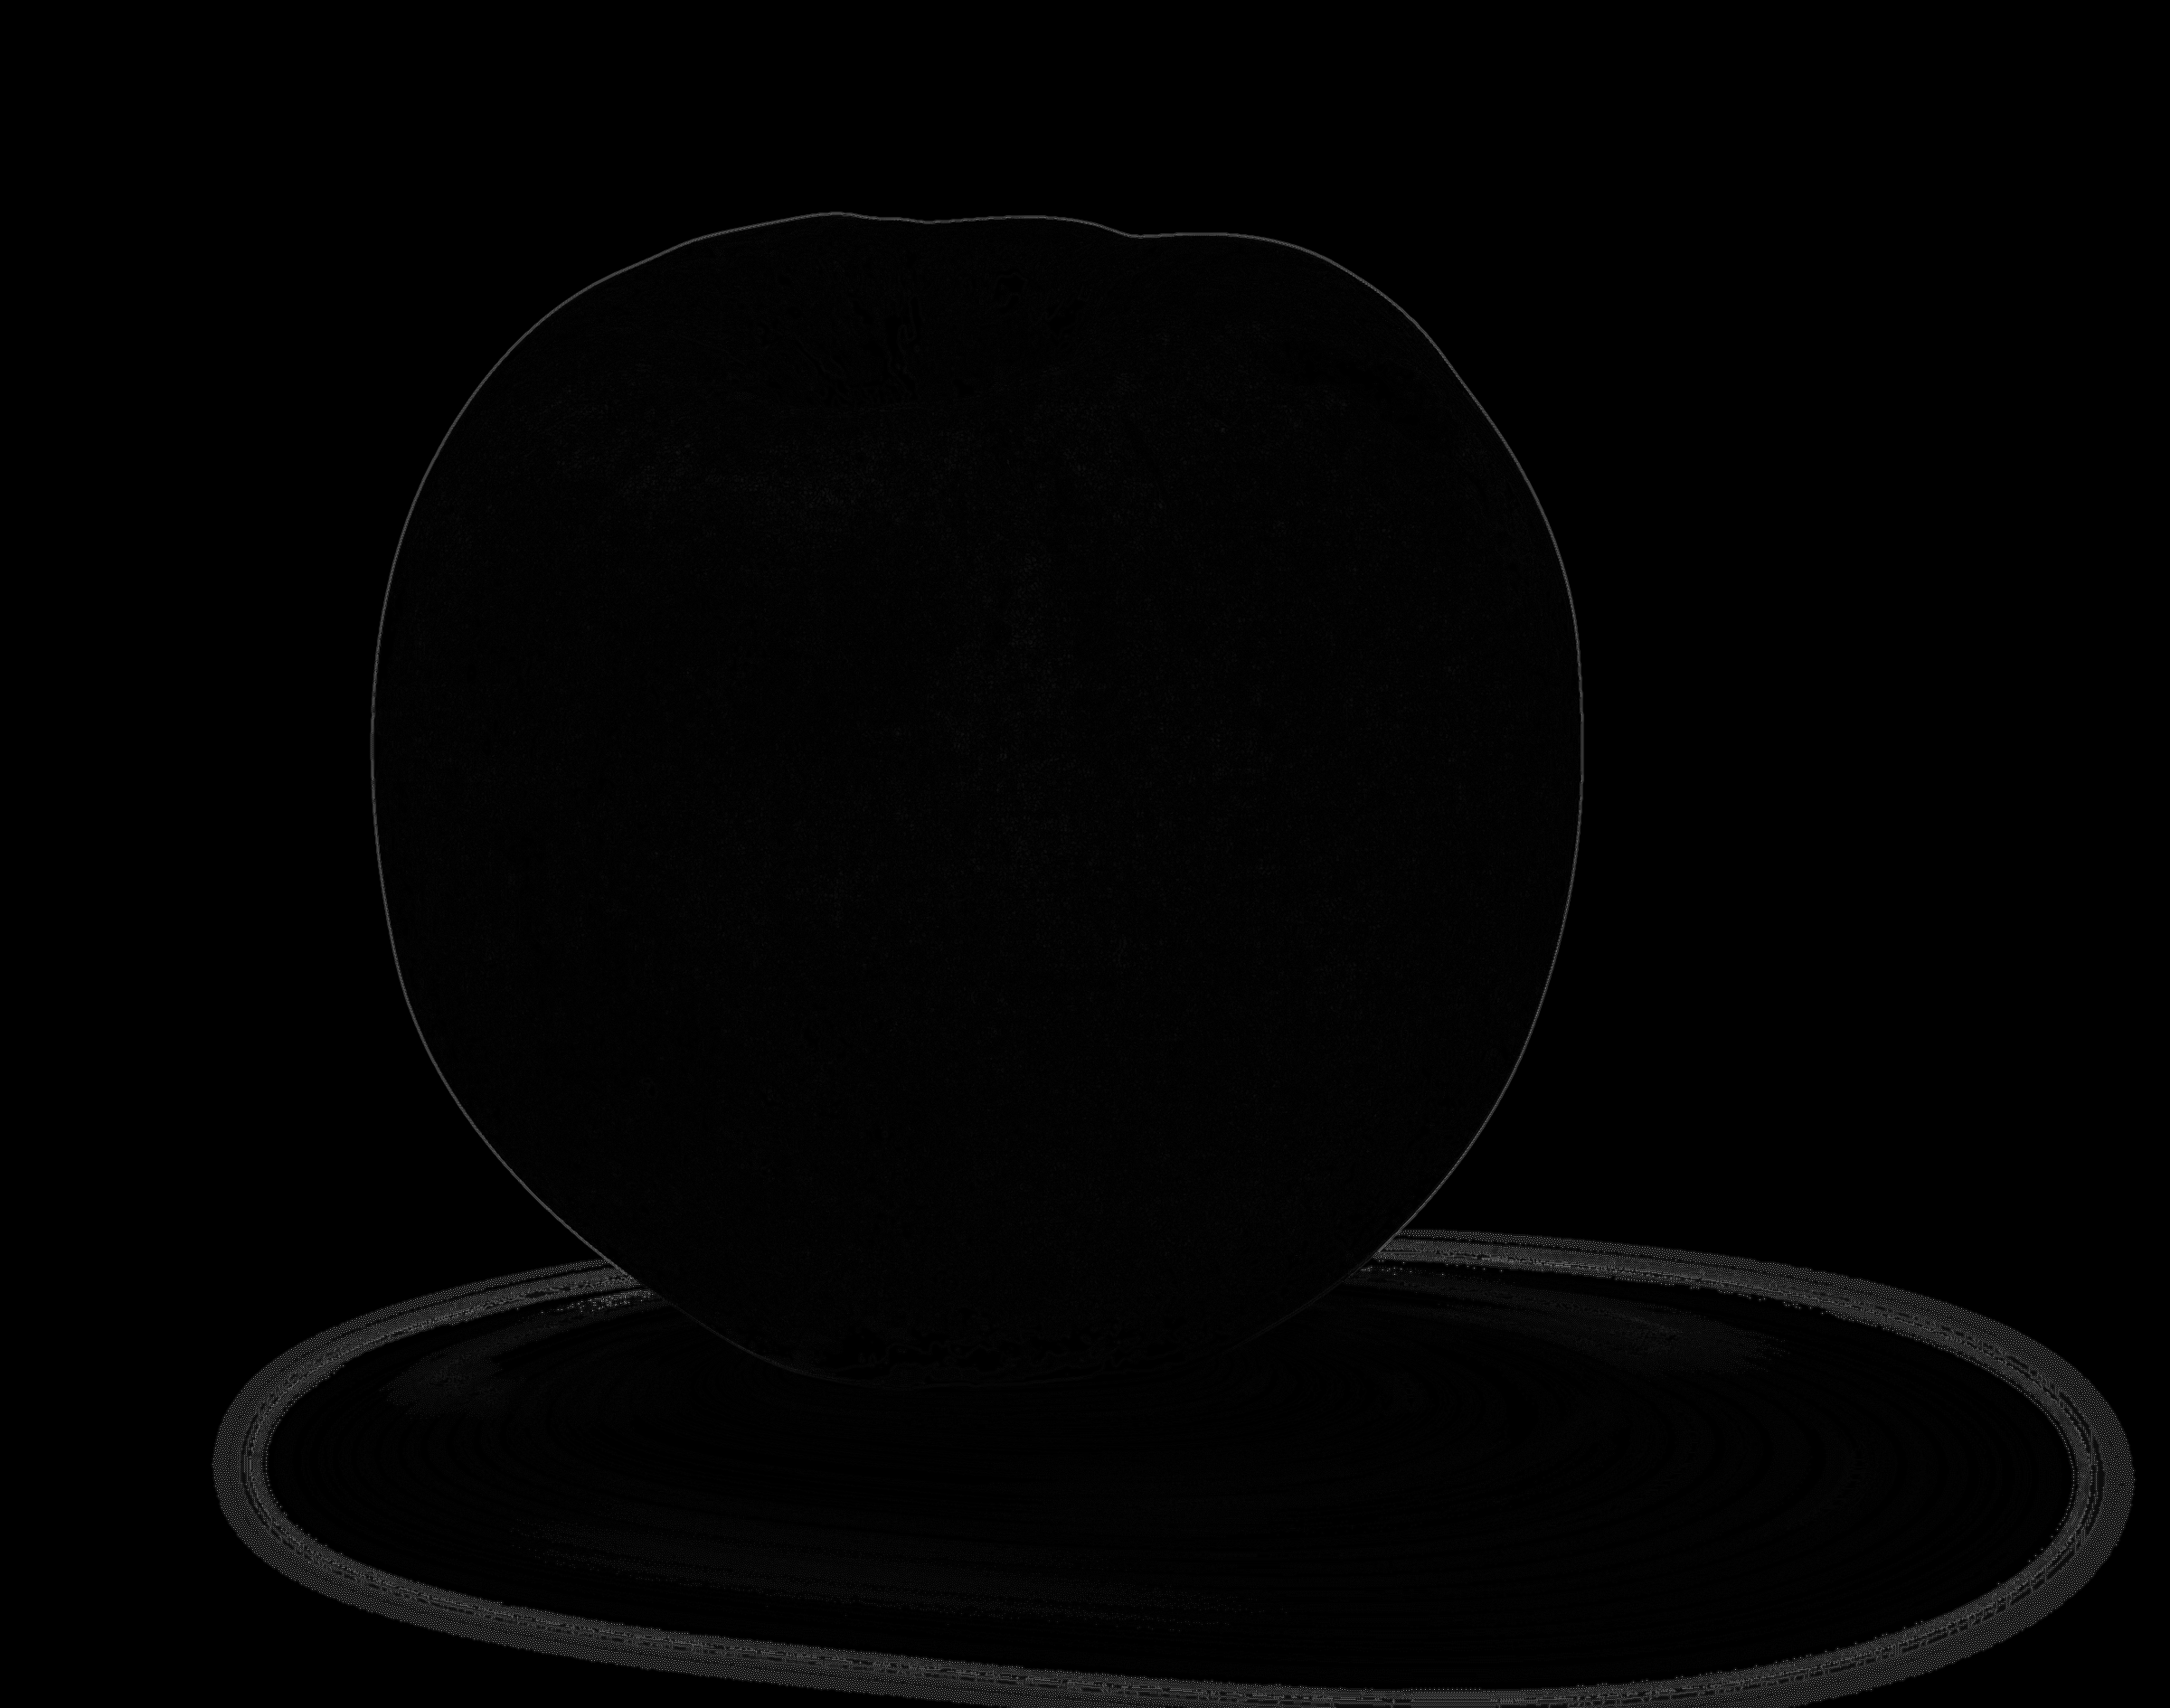

Displaying result for img.png:


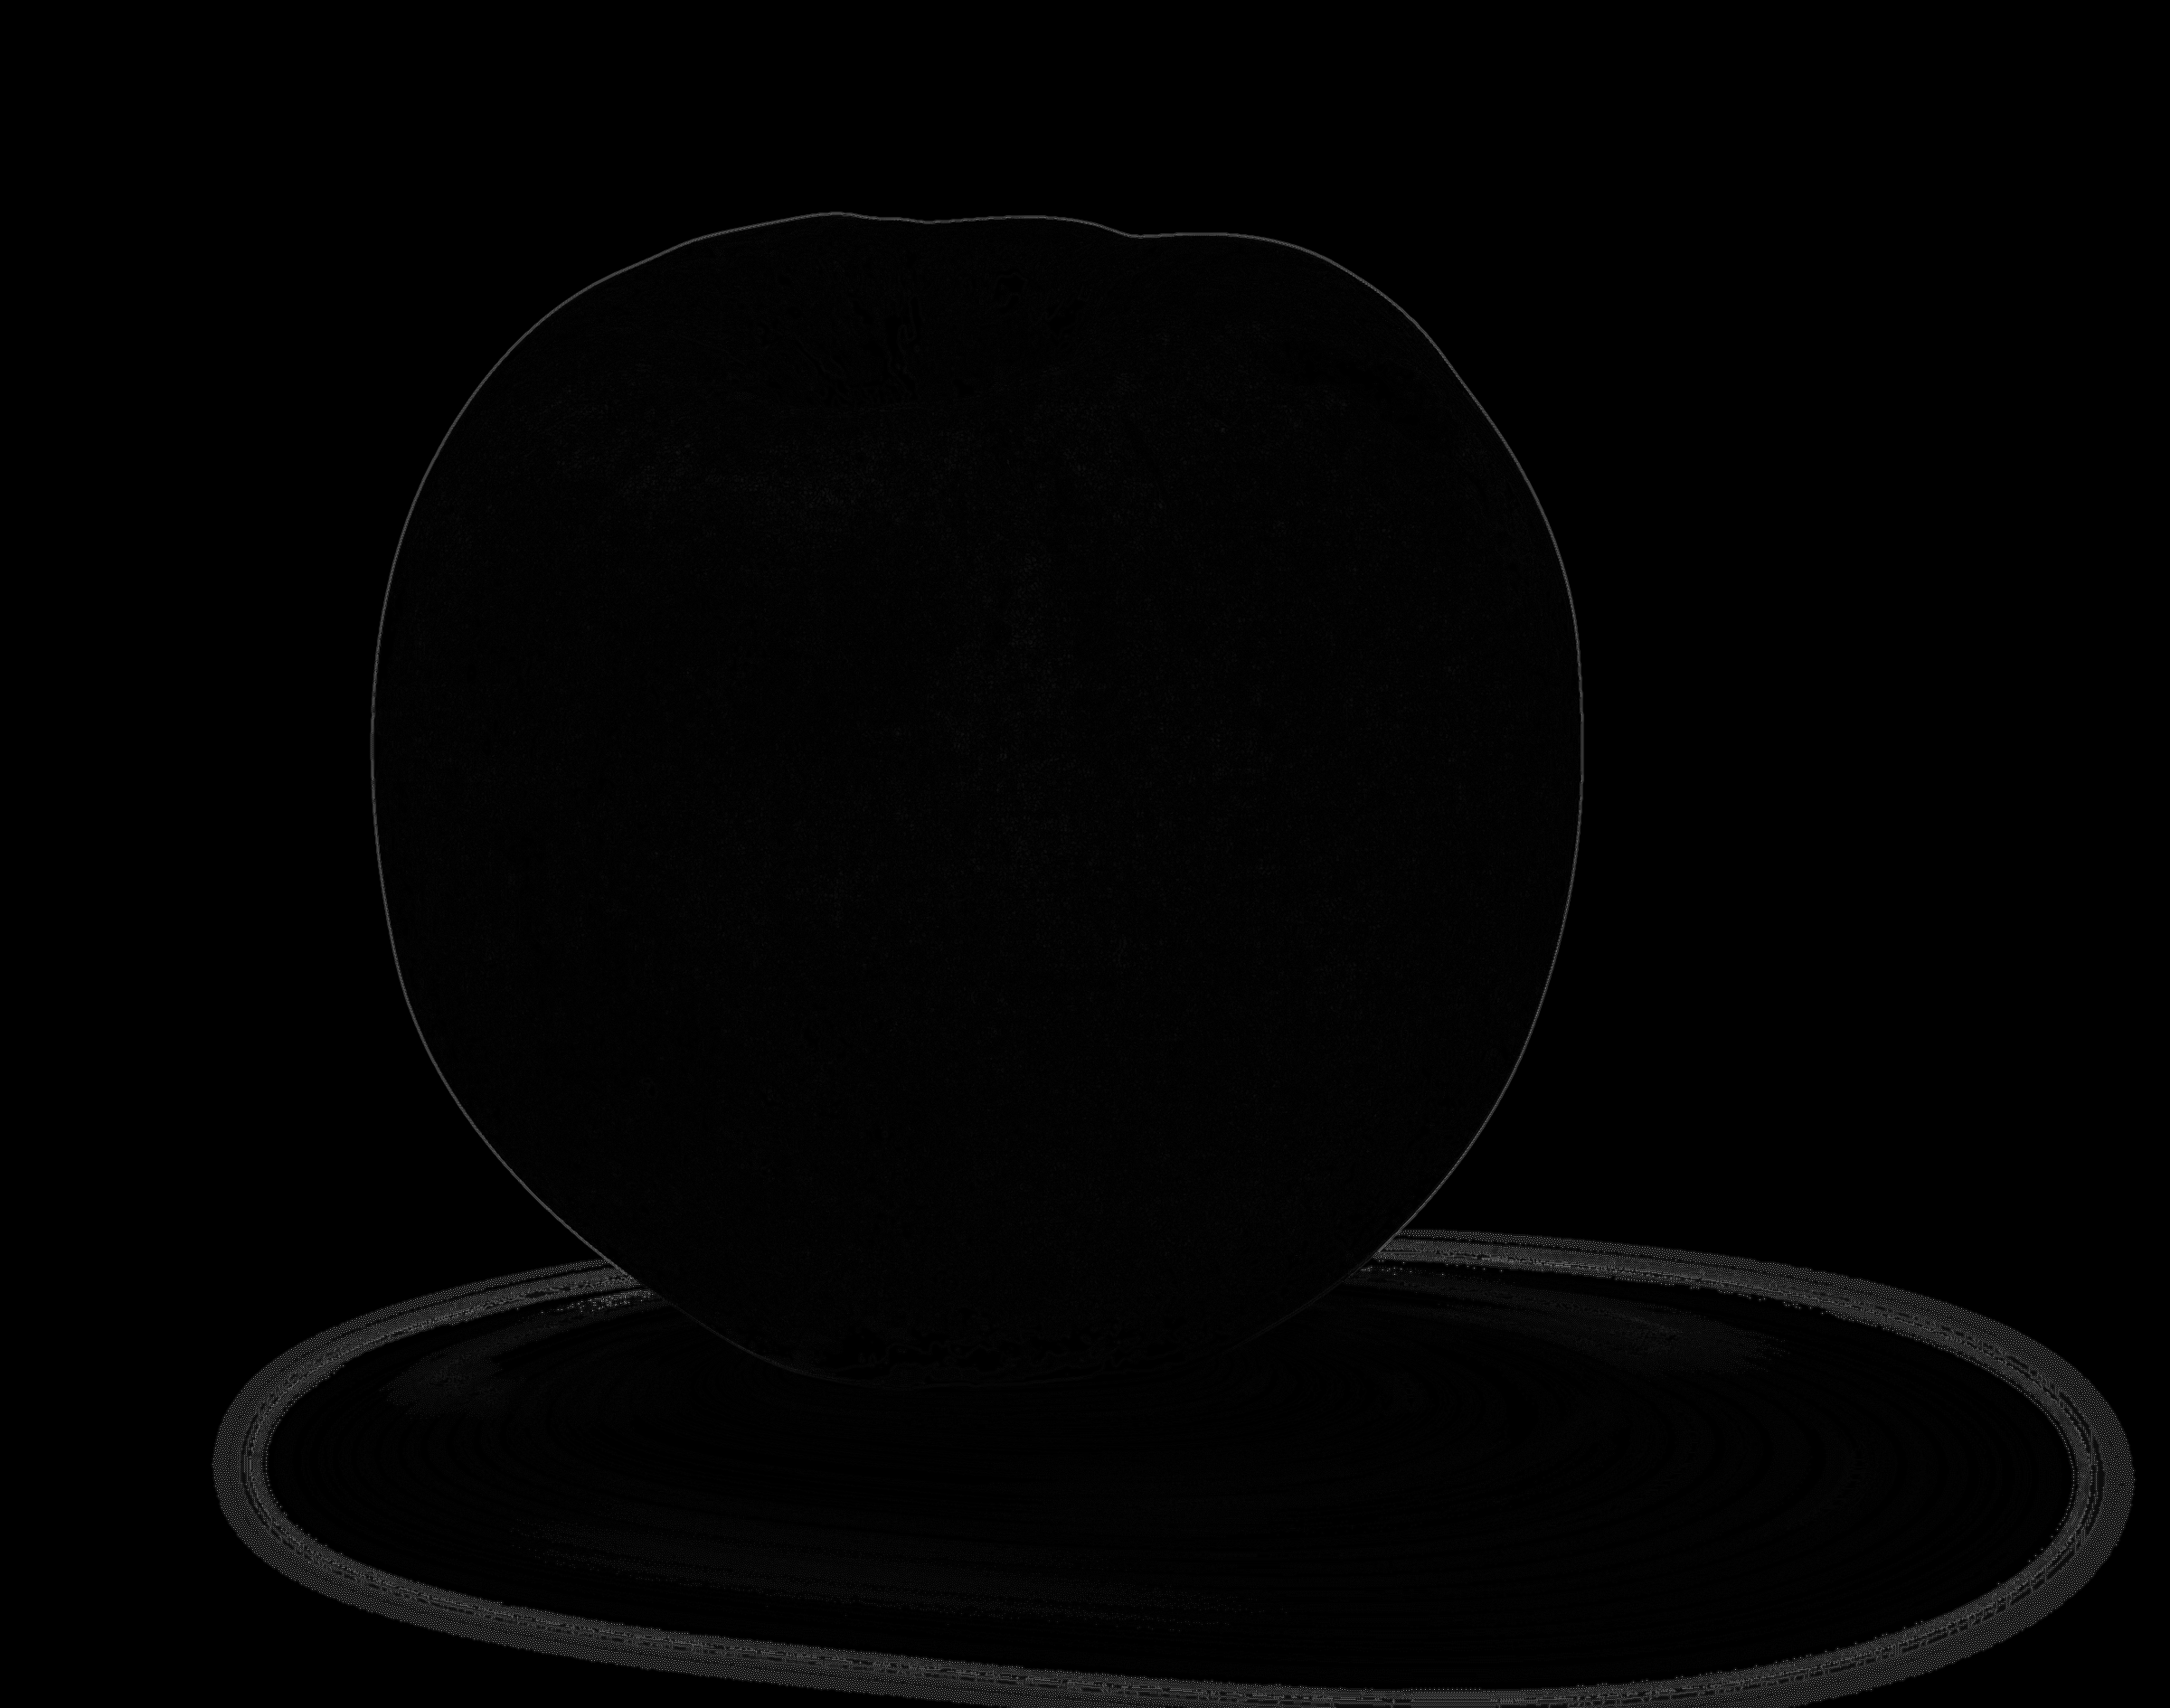

In [534]:
# Apply the LoG kernel to both images
log_img1 = apply_log_kernel(img1)
log_img = apply_log_kernel(img)

# Display the results using cv2_imshow
print("Displaying result for img1.png:")
imshow(log_img1)

print("Displaying result for img.png:")
imshow(log_img)

In [535]:
def blur_image(image, kernel_size=(5, 5)):
    """
    Function to apply Gaussian blur on an image and return the blurred image.

    Args:
    - image (numpy array): Input image to be blurred.
    - kernel_size (tuple): Size of the kernel to use for the blur, e.g., (5, 5) for a 5x5 kernel.

    Returns:
    - blurred_image (numpy array): Blurred version of the input image.
    """
    # Apply Gaussian blur with the given kernel size
    blurred_image = cv2.GaussianBlur(image, kernel_size, 0)

    return blurred_image

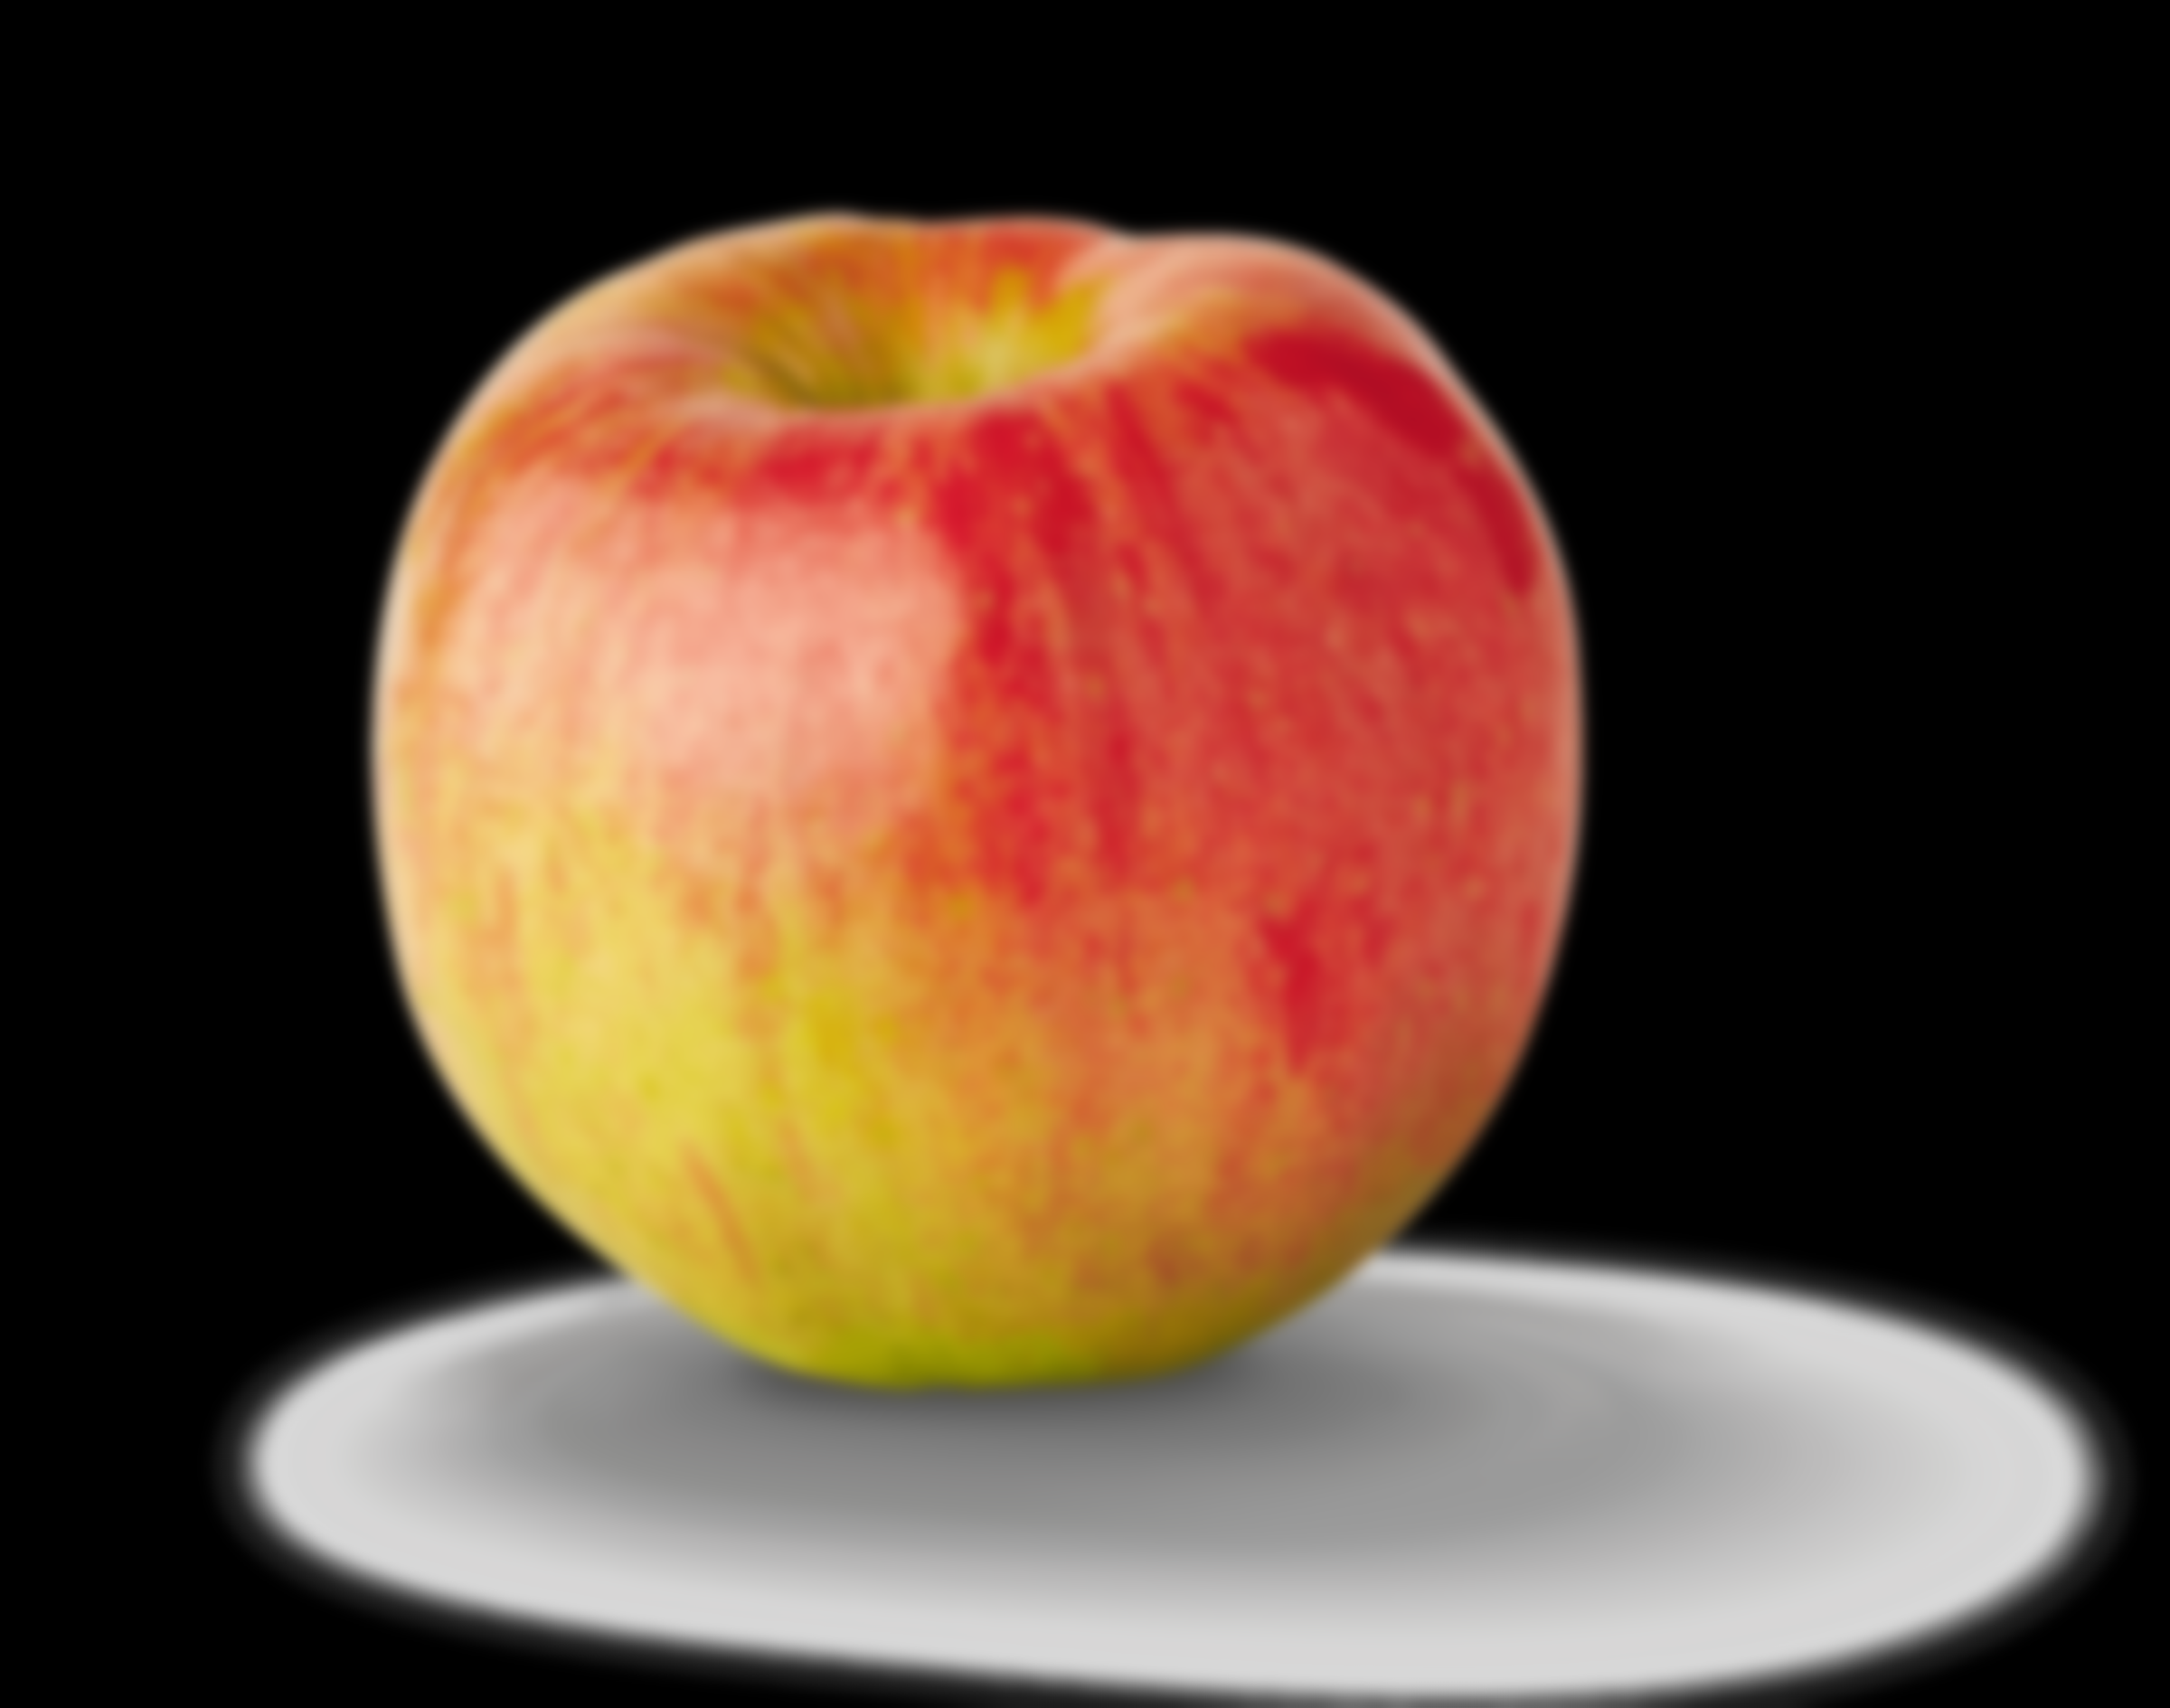

In [536]:
blurred_img = blur_image(img1, kernel_size=(55, 55))
imshow(blurred_img)

In [537]:
def detect_circles(image, min_radius=30, max_radius=800, param1=50, param2=40):
    """
    Function to detect circles in an image using the Hough Circle Transform.

    Args:
    - image (numpy array): Input image on which circles need to be detected.
    - min_radius (int): Minimum radius of the circles to detect.
    - max_radius (int): Maximum radius of the circles to detect.
    - param1 (int): First method-specific parameter for edge detection (higher is stricter).
    - param2 (int): Second method-specific parameter for circle center detection (lower is stricter).

    Returns:
    - circles (numpy array): Detected circles, each represented by [x, y, r] (center and radius).
    """
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to reduce noise and improve circle detection
    blurred = cv2.GaussianBlur(gray, (15, 15), 0)

    # Apply the Hough Circle Transform to detect circles
    circles = cv2.HoughCircles(
        blurred,
        cv2.HOUGH_GRADIENT, dp=1.2, minDist=75,
        param1=param1, param2=param2, minRadius=min_radius, maxRadius=max_radius
    )

    # If circles are detected, round them and return
    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
        return circles
    return []

def draw_circles(image, circles):
    """
    Function to draw circles on an image.

    Args:
    - image (numpy array): Input image to draw the circles on.
    - circles (numpy array): Detected circles (each circle is [x, y, r]).

    Returns:
    - image_with_circles (numpy array): Image with circles drawn.
    """
    image_with_circles = image.copy()

    for (x, y, r) in circles:
        # Draw the circle outline
        cv2.circle(image_with_circles, (x, y), r, (0, 255, 0), 4)
        # Draw the center of the circle
        cv2.circle(image_with_circles, (x, y), 3, (0, 0, 255), 3)

    return image_with_circles

In [541]:
def is_apple_color(pixel_values, red_threshold=100, green_threshold=50, blue_threshold=50):
    """
    Function to check if the color distribution of the pixels suggests it's an apple.

    Args:
    - pixel_values (numpy array): Array of pixel values from the circle area.
    - red_threshold (int): Minimum red intensity for apple-like color.
    - green_threshold (int): Minimum green intensity for apple-like color.
    - blue_threshold (int): Maximum blue intensity to avoid blue objects.

    Returns:
    - bool: True if the color distribution suggests the circle is likely an apple.
    """
    # Extract red, green, and blue channels
    red_pixels = pixel_values[:, 2]
    green_pixels = pixel_values[:, 1]
    blue_pixels = pixel_values[:, 0]

    # Count pixels that are above the threshold for red and green
    red_pixels_above_threshold = np.sum(red_pixels >= red_threshold)
    green_pixels_above_threshold = np.sum(green_pixels >= green_threshold)

    # Count pixels that are below the threshold for blue
    blue_pixels_below_threshold = np.sum(blue_pixels < blue_threshold)

    # To be considered an apple, we need enough red and green pixels,
    # and not too many blue pixels
    if red_pixels_above_threshold > 0 and green_pixels_above_threshold > 0:
        # Ensure that blue pixels are not dominant
        if blue_pixels_below_threshold > len(pixel_values) * 0.2:  # Allow up to 20% blue pixels
            return True

    return False

In [539]:
def remove_contained_circles(circles, image):
    """
    Function to remove circles that are fully contained within another circle,
    and also validate that the circle corresponds to an apple based on its color.

    Args:
    - circles (numpy array): Detected circles (each circle is [x, y, r]).
    - image (numpy array): The image from which the circles were detected.

    Returns:
    - filtered_circles (numpy array): Circles that are not fully contained within another circle
      and are likely apples.
    """
    # List to store circles that are not contained and likely apples
    filtered_circles = []

    # Get image dimensions
    height, width = image.shape[:2]

    # Iterate over each circle
    for i, (x1, y1, r1) in enumerate(circles):
        is_contained = False

        # Create a mask for the current circle
        mask = np.zeros((height, width), dtype=np.uint8)
        cv2.circle(mask, (x1, y1), r1, 255, -1)  # Create a circular mask

        # Extract the region inside the circle using the mask
        circle_region = cv2.bitwise_and(image, image, mask=mask)

        # Only keep non-zero pixels (i.e., the pixels inside the circle)
        circle_pixels = circle_region[mask != 0]

        # Check if the color distribution suggests it's an apple
        if not is_apple_color(circle_pixels):
            continue

        # Check for containment
        for j, (x2, y2, r2) in enumerate(circles):
            if i == j:
                continue

            distance = np.sqrt((x1 - x2)**2 + (y1 - y2)**2)
            if distance < abs(r1 - r2):
                is_contained = True
                break

        # If the circle is not contained and is a valid apple, add it to the filtered list
        if not is_contained:
            filtered_circles.append((x1, y1, r1))

    return np.array(filtered_circles)

Displaying result for img1.png:


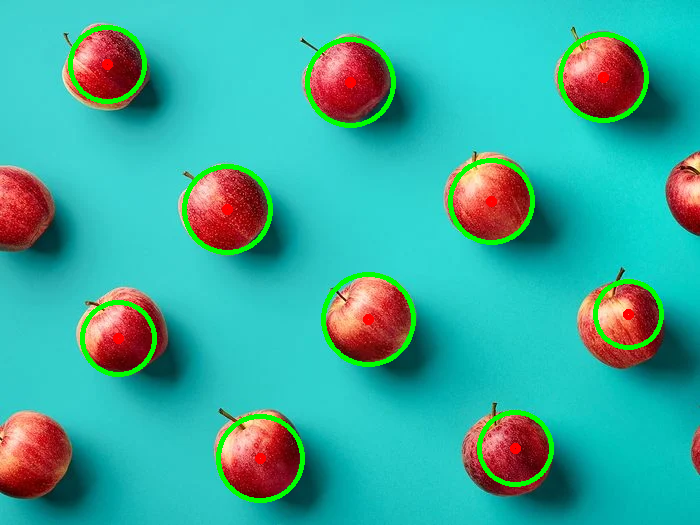

In [543]:
imgx = img3

# Apply the LoG kernel to both images
circles = detect_circles(imgx)
# Remove circles that are fully contained within another circle
filtered_circles = remove_contained_circles(circles, imgx)

# Draw the filtered circles on the image
img_with_filtered_circles = draw_circles(imgx, filtered_circles)

# Display the results using cv2_imshow
print("Displaying result for img1.png:")
imshow(img_with_filtered_circles)

